In [1]:
import matplotlib.pyplot as plt

import pickle
import pandas as pd
import numpy as np
import os.path
import regex # allows alternatives in negative lookarounds
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics

# from corpus_characterization_utils import *

from utils import utils
from ThoughtGrapher import ThoughtGrapher

tgraph = ThoughtGrapher()

SENTENCE_TRANSFORMER_MODEL_NAME = 'all-MiniLM-L6-v2'

DATA_FILE = f'dolly_data_{SENTENCE_TRANSFORMER_MODEL_NAME}.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'
dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
    'inst_A':'instruction_A', 'inst_B':'instruction_B',
    'resp_A':'response_A', 'resp_B': 'response_B',
})
dolly_data

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,response_B
15002,Which is a species of fish? Banjo or Guitar,,Banjo,classification,False,"[-0.031613580882549286, 0.02204715646803379, -...","[-0.058731645345687866, 0.02958996407687664, -...",inst_A08,inst_B51,resp_A01,resp_B001
19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,False,"[-0.023818423971533775, 0.04866934195160866, -...","[-0.047977667301893234, 0.007309707347303629, ...",inst_A09,inst_B53,resp_A01,resp_B001
27,Identify which instrument is string or woodwin...,,"Zurna is woodwind, Panduri is string.",classification,False,"[-0.007988017983734608, 0.05960787460207939, -...","[0.005874082446098328, 0.03250544145703316, -0...",inst_A09,inst_B53,resp_A01,resp_B001
62,Identify which instrument is string or percuss...,,"Shamisen is string, Kpanlogo is percussion.",classification,False,"[0.04195571690797806, 0.03711291775107384, -0....","[0.05845625326037407, 0.008080583065748215, -0...",inst_A09,inst_B53,resp_A01,resp_B001
90,Identify which instrument is string or percuss...,,"Viola toeria is string, Samphor is percussion.",classification,False,"[0.031926609575748444, -0.01929675228893757, -...","[0.04793274775147438, -0.04417796805500984, -0...",inst_A09,inst_B53,resp_A01,resp_B001
...,...,...,...,...,...,...,...,...,...,...,...
8421,What are some interesting facts about Nelson M...,Nelson Mandela Boulevard (Persian: بلوار نلسون...,It holds a mixture of residential and commerci...,summarization,True,"[0.039251651614904404, 0.09270037710666656, -0...","[0.09583701938390732, 0.03630739822983742, -0....",inst_A15,inst_B85,resp_A15,resp_B101
10200,What is the best way to get from London to Paris.,,To travel from London to Paris you have severa...,general_qa,False,"[0.10140563547611237, -0.03675508126616478, 0....","[0.04922645539045334, -0.06915348023176193, 0....",inst_A15,inst_B85,resp_A15,resp_B101
14919,Given a reference text that describes the air ...,In response to concerns that volcanic ash ejec...,Initially there was an uninterrupted shutdown ...,closed_qa,True,"[0.023408792912960052, 0.04394981265068054, 0....","[0.07181950658559799, -0.014206488616764545, 0...",inst_A15,inst_B86,resp_A15,resp_B101
6012,What is a good slogan for carpet?,,Here are some good slogans for carpet:\n\n- Th...,brainstorming,False,"[0.003218281315639615, 0.034283023327589035, 0...","[0.0023823166266083717, -0.02614438533782959, ...",inst_A15,inst_B89,resp_A15,resp_B101


In [3]:

MODELS_FILE = f'aspect_models_LogisticRegressionCV_{SENTENCE_TRANSFORMER_MODEL_NAME}.pkl'

# Prefixing patterns by r'\b' ensures they must be at the beginning of a word. 
# This way 'eat' does not match 'great', and most plurals will be OK.
patterns = { 
    # domains
    'cars': r"\b(automobile|car|Toyota|Ford|Dodge|Jeep|Fiat)",
    'animals': r"\b(animal|cat|dog|pet)",
    'food': r"\b(food|diet|eat|restaurant)",
    'programming_language': r"\bprogramming language",
    'sports': r'\baseball(?!: bat)|basketball|badminton|tennis(?!: shoe)|soccer|futbol|football (?!: stadium)',
    'science': r"(?<![:?])(?<!(computer|political|data)) science (?!fiction)|biology|(?<!blood )chemistry|physics|astromony",
    'science_fiction': r"science fiction",
    'data_science': r"data science|machine learning|statistic|quantitative|probability|artificial intelligence|AI\b",
    'information_technology': r"technology|software|information|open source|spark",
    'books': r"\b(book(?!: a )|books|novel|literature|literary)\b",  # 'book' but not 'book a flight'

    # instructions
    'identify': r'identify|classify|which',
    'how_does': r'how (do|does)\b',
    'why_is': r'why (is|are)',
    'what is': r'what (is|are)',
    'extract': r'extract ([^:.?]+) from',
    'of_the_following': r'of the following',
    
    # instruction structure
    'given_text': r"\b(given a|given the|the given|based on|reference text|as a reference|the following text)",  # passage|paragraph
    'alternatives': r',|\b(or)\b',

    # output format
    'output_format': r"(display|the results|as a (bulleted )?list|list them|format this|format them|in the format|each record|new line|comma separated|separated by|separate them with a comma|JSON|XML|markdown)", 
}


if os.path.exists(MODELS_FILE):
    models = pickle.load( open(MODELS_FILE, 'rb') )

else:
    models = {}
    
    for text_col in ['instruction', 'response']:
        vector_col = text_col + "_vector"
        l1_ratios = [0.01, 0.1, 0.5]
        X = [v for v in dolly_data[vector_col]]
        for topic in patterns.keys():
            pattern = patterns[topic]
            flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in dolly_data[text_col]]
            # clf = LogisticRegression(C=1, max_iter=10000)
            clf = LogisticRegressionCV(cv=5, scoring='roc_auc', # fit_intercept=False, 
                                       n_jobs=-1, max_iter=10000)
            # clf = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, scoring='roc_auc', max_iter=10000)
            clf.fit(X, flags)
            flag_col = text_col + '_' + topic
            score_col = flag_col + '_score'
            models[flag_col] = {'model': clf, 'flags': flags, 'scores': clf.predict_proba(X)[:,1]}
            # dolly_data[flag_col] = flags
            # dolly_data[score_col] = clf.predict_proba(X)[:,1]
    
    pickle.dump(models, open(MODELS_FILE, 'wb'))


for flag_col in models.keys():
    model_info = models[flag_col]
    dolly_data[flag_col] = model_info['flags']
    score_col = flag_col + '_score'
    dolly_data[score_col] = model_info['scores']

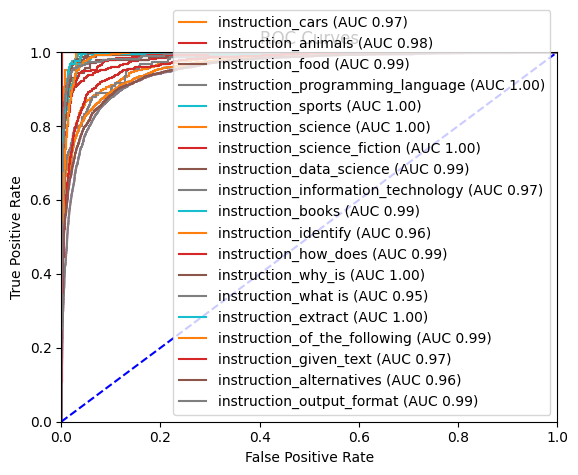

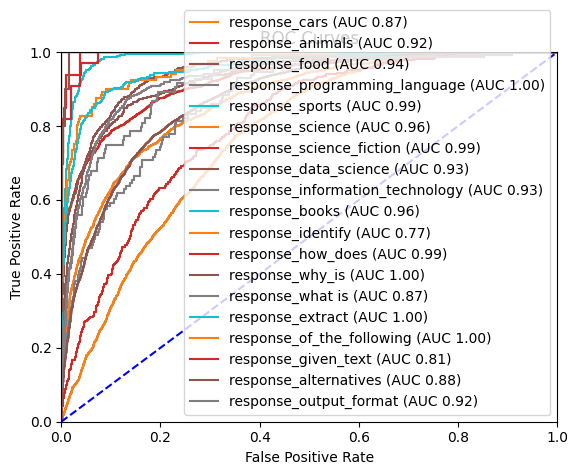

In [4]:
# list( models.keys() )

def plot_multiple_ROC_curves(score_flag_dict):
    plt.title('ROC Curves')
    for target in score_flag_dict.keys():
        model_info = score_flag_dict[target]
        fpr, tpr, threshold = metrics.roc_curve(model_info['flags'], model_info['scores'])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot(fpr, tpr, #'b', 
                 label = f'{target} (AUC {roc_auc:0.2f})')

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('instruction')})

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('response')})

In [5]:
def get_model_stats(my_models):
    all_models_stats = []
    for topic in my_models:
        my_stats = {}
        model = my_models[topic]['model']
        cv_scores = [ max(vc) for vc in model.scores_[True] ]  # (n_folds, n_cs)
        my_stats['topic'] = topic
        my_stats['number_of_cases'] = np.sum(my_models[topic]['flags'])
        my_stats['cv_auc_mean'] = np.mean(cv_scores)
        my_stats['intercept'] = model.intercept_[0]
        my_stats['coef_std'] = np.std(model.coef_[0])
        my_stats['coef_min'] = np.min(model.coef_[0])
        my_stats['coef_mean'] = np.mean(model.coef_[0])
        my_stats['coef_max'] = np.max(model.coef_[0])
        all_models_stats.append(my_stats)
        
    return pd.DataFrame(all_models_stats)


model_stats = get_model_stats(models)
model_stats

,topic,number_of_cases,cv_auc_mean,intercept,coef_std,coef_min,coef_mean,coef_max
0,instruction_cars,536,0.901369,-5.514938,2.870177,-7.915646,-3.483665e-01,9.054671
1,instruction_animals,694,0.959107,-4.444007,1.505176,-3.728922,-6.013031e-02,4.686525
2,instruction_food,233,0.980549,-6.481981,1.177250,-3.876871,3.700957e-03,4.252732
3,instruction_programming_language,24,0.999933,-16.873609,2.216473,-5.975073,3.331303e-02,7.623810
4,instruction_sports,343,0.986970,-6.617523,1.268126,-3.896551,-4.271812e-02,3.833336
5,instruction_science,21,0.981805,-6.571004,0.002937,-0.009120,9.732552e-06,0.009874
6,instruction_science_fiction,17,0.989774,-8.047238,0.607449,-1.823362,4.008987e-04,1.415780
7,instruction_data_science,141,0.901828,-7.590975,2.574285,-7.324217,-1.670508e-01,7.932527
8,instruction_information_technology,155,0.882749,-5.403396,1.113617,-3.395230,-2.122882e-02,3.174848
9,instruction_books,218,0.991034,-5.098919,0.568549,-1.801276,4.142023e-03,1.742671


In [76]:
target_model = 'instruction_sports'
vector_col = 'instruction_vector'

clf = models[target_model]['model']

dd2 = utils.add_cluster_cols(dolly_data, embedding_col='instruction_vector', prefix='unweighted_cl', letters='A', max_threshold=10)
dd2['score'] = clf.predict_proba( X = [v for v in dolly_data[vector_col]] )[:,1]
dd2['weighted_instruction_vector'] = [ v * clf.coef_[0] for v in dolly_data[vector_col]]
dd2['inverse_weighted_instruction_vector'] = [ v / clf.coef_[0] for v in dolly_data[vector_col]]

# dd2 = utils.add_cluster_cols(dd2, embedding_col='weighted_instruction_vector', prefix='weighted_cl', letters='AB', max_threshold=10)
# dd2 = utils.add_cluster_cols(dd2, embedding_col='inverse_weighted_instruction_vector', prefix='inverse_weighted_cl', letters='AB', max_threshold=10)


In [80]:
from sklearn.cluster import KMeans

def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column='score', aggfunc='mean'), 
        score_std =pd.NamedAgg(column='score', aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0
unweighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['instruction_vector']])
weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['weighted_instruction_vector']])
inverse_weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['inverse_weighted_instruction_vector']])

dd2['unweighted_kmeans'] = unweighted_kmeans.labels_
dd2['weighted_kmeans'] = weighted_kmeans.labels_
dd2['inverse_weighted_kmeans'] = inverse_weighted_kmeans.labels_

cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

In [99]:
dd2[ ['unweighted_kmeans', 'weighted_kmeans', 'inverse_weighted_kmeans', 'score'] ].to_csv('reweighted_cluster_scores.csv', index=False)

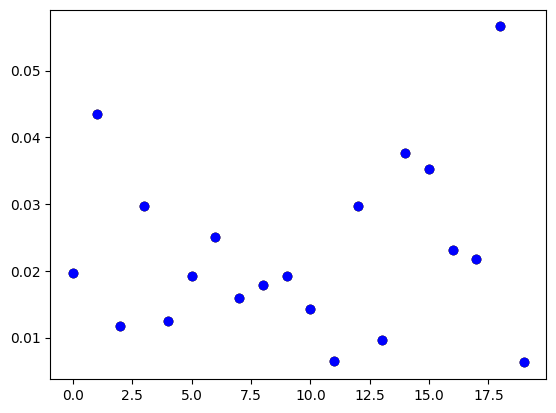

In [95]:
# cs_inverse_weighted.plot.scatter(x='cluster_id', y='score_mean')
# cs_unweighted.plot.scatter(x='cluster_id', y='score_mean')

plt.scatter(cs_unweighted['cluster_id'], cs_inverse_weighted['score_mean'], c='r')
plt.scatter(cs_weighted['cluster_id'], cs_inverse_weighted['score_mean'], c='g')
plt.scatter(cs_inverse_weighted['cluster_id'], cs_inverse_weighted['score_mean'], c='b')

In [81]:
cs_inverse_weighted

,cluster_id,score_mean,score_std
0,0,0.019663,0.105115
1,1,0.043521,0.141821
2,2,0.011683,0.069329
3,3,0.029693,0.113970
4,4,0.012433,0.082562
5,5,0.019228,0.104877
6,6,0.025065,0.114387
7,7,0.015858,0.086038
8,8,0.017849,0.105170
9,9,0.019158,0.091901


In [45]:
get_cluster_stats(dd2, 'unweighted_cl_A', 'score')

,score_mean,score_std
unweighted_cl_A,,
unweighted_cl_A01,0.004256,0.032978
unweighted_cl_A02,0.003659,0.010514
unweighted_cl_A03,0.058501,0.179550
unweighted_cl_A04,0.062563,0.170992
unweighted_cl_A05,0.003870,0.036275
unweighted_cl_A06,0.001959,0.003191
unweighted_cl_A07,0.002077,0.007788
unweighted_cl_A08,0.019215,0.097403
unweighted_cl_A09,0.003243,0.030855


In [46]:
get_cluster_stats(dd2, 'weighted_cl_A', 'score')

,score_mean,score_std
weighted_cl_A,,
weighted_cl_A01,0.004904,0.021728
weighted_cl_A02,0.003533,0.021987
weighted_cl_A03,0.001986,0.009904
weighted_cl_A04,0.001608,0.005310
weighted_cl_A05,0.241410,0.296544
weighted_cl_A06,0.002965,0.020898
weighted_cl_A07,0.003982,0.004380
weighted_cl_A08,0.002437,0.020244
weighted_cl_A09,0.001465,0.002297


In [47]:
get_cluster_stats(dd2, 'inverse_weighted_cl_A', 'score')

,score_mean,score_std
inverse_weighted_cl_A,,
inverse_weighted_cl_A01,0.019937,0.093017
inverse_weighted_cl_A02,0.030437,0.140884
inverse_weighted_cl_A03,0.013995,0.077748
inverse_weighted_cl_A04,0.017838,0.101183
inverse_weighted_cl_A05,0.008456,0.064884
inverse_weighted_cl_A06,0.005795,0.037868
inverse_weighted_cl_A07,0.016693,0.091539
inverse_weighted_cl_A08,0.041285,0.146561
inverse_weighted_cl_A09,0.018408,0.095035


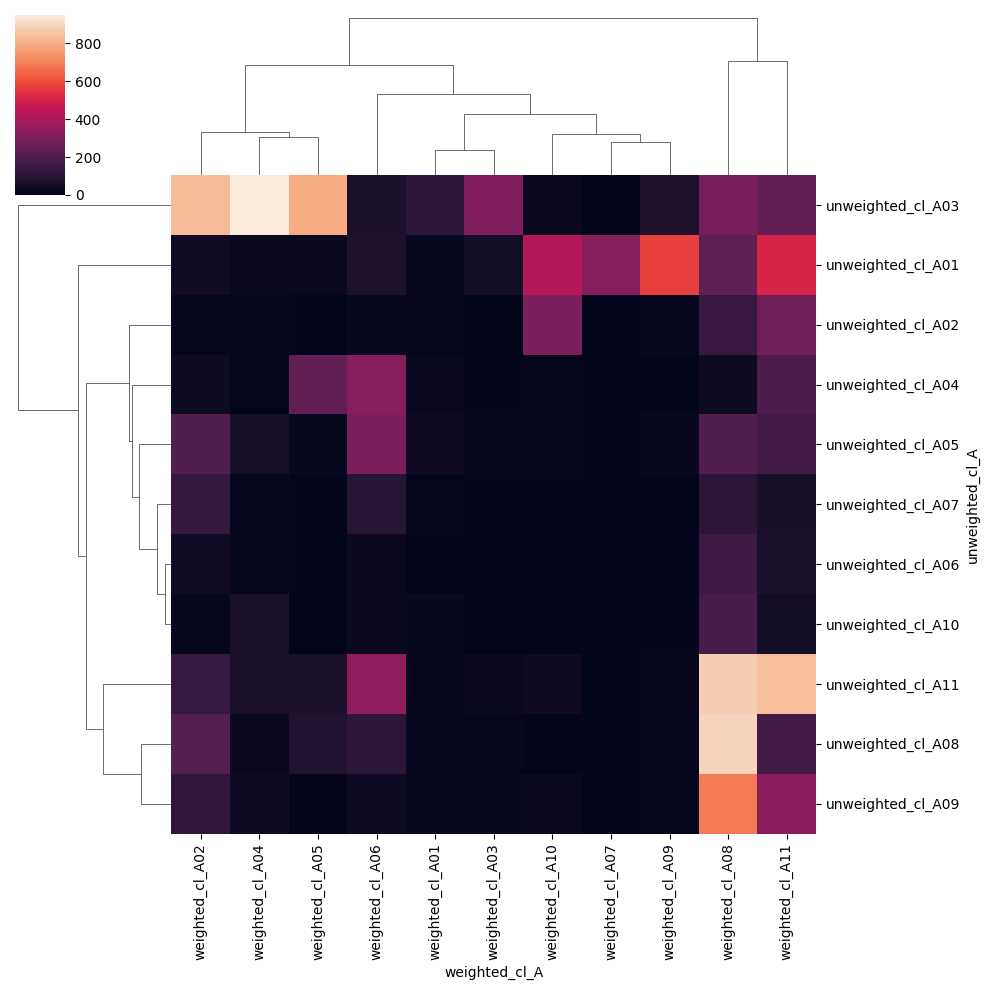

In [20]:
import seaborn as sns

wu_xtab = pd.crosstab(dd2['unweighted_cl_A'], dd2['weighted_cl_A'])

sns.clustermap(wu_xtab)

In [ ]:
framework_models = [ 'instruction_' + x for x in ['given_text', 'alternatives', 'output_format', 
                                                  'identify', 'how_does', 'why_is', 'what is', 'extract']]


In [ ]:
M_coef = pd.DataFrame([models[topic]['model'].coef_[0] for topic in models.keys()] , index=[k for k in models.keys()]).transpose()
print("number of coefficients:", len(M_coef))  # one row per embedding dimension

M_coef